In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append("../")

# choose whether to work on a remote machine
location = "remote"
if location == "remote":
    # change this line to the where the GitHub repository is located
    os.chdir("/lustre_scratch/orlando-code/coralshift/")

In [2]:
from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np
import json
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn import model_selection

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklmetrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RandomizedSearchCV


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
import rioxarray as rio
import pickle

from coralshift.utils import directories, file_ops, utils
from coralshift.processing import spatial_data, baselines
from coralshift.plotting import spatial_plots, model_results

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/lustre_scratch/conda-envs/coralshift/share/proj failed


## Data Derivation

In [3]:
def load_and_process_reproducing_xa_das() -> list[xa.DataArray]:
    """
    Load and process xarray data arrays for reproducing metrics.

    Returns
    -------
        list[xa.DataArray]: A list containing the processed xarray data arrays.
    """
    # load in daily sea water potential temp
    thetao_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/thetao.nc")
    
    # load in daily sea water salinity means
    salinity_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/so.nc")

    # load in daily latitudinal and longitudinal currents
    uo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/uo.nc")
    vo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/vo.nc")
    # calculate current magnitude
    current_daily = baselines.calculate_magnitude(uo_daily, vo_daily).rename("current")

    bathymetry = xa.open_dataset(
        directories.get_bathymetry_datasets_dir() / "bathymetry_A_0-00030d.nc").rio.write_crs("EPSG:4326")["bathymetry_A"]

    # Load in ERA5 surface net solar radiation and upscale to climate variable resolution
    solar_radiation = xa.open_dataarray(
        directories.get_era5_data_dir() / "weather_parameters/VAR_surface_net_solar_radiation_LATS_-10_-17_LONS_142_147_YEAR_1993-2020.nc"
        ).rio.write_crs("EPSG:4326")
    # average solar_radiation daily
    solar_radiation_daily = solar_radiation.resample(time="1D").mean(dim="time")

    # Load in ground truth data
    gt_1000m = xa.open_dataarray(directories.get_processed_dir() / "arrays/coral_raster_1000m.nc").rename("gt")

    return [thetao_daily, salinity_daily, current_daily, solar_radiation_daily, bathymetry, gt_1000m]


def resample_list_xa_ds_to_target_resolution_and_merge(xa_das: list[xa.DataArray], target_resolution: float, 
    unit: str = "m", lat_lims: tuple[float] = (-10,-17), lon_lims: tuple[float] = (142,147)) -> dict:
    """
    Resample a list of xarray DataArrays to the target resolution and merge them.

    Parameters
    ----------
        xa_das (list[xa.DataArray]): A list of xarray DataArrays to be resampled and merged.
        target_resolution (float): The target resolution for resampling.
        unit (str, defaults to "m"): The unit of the target resolution.
        interp_method: (str, defaults to "linear") The interpolation method for resampling.

    Returns
    -------
        A dictionary containing the resampled xarray DataArrays merged by their names.
    """
    # TODO: will probably need to save to individual files/folders and combine at test/train time
    # may need to go to target array here
    target_resolution_d = spatial_data.choose_resolution(target_resolution, unit)[1]
    dummy_xa = generate_dummy_xa(target_resolution_d, lat_lims, lon_lims)

    resampled_xa_das_dict = {}
    for xa_da in tqdm(xa_das, desc = "Resampling xarray DataArrays"):

        xa_resampled = upsample_xa_d_to_other(xa_da, dummy_xa, name=xa_da.name)

        resampled_xa_das_dict[xa_da.name] = xa_resampled
    
    return resampled_xa_das_dict
    



def find_index_pair(xa_da, lat, lon, lat_spacing, lon_spacing):
    # Get the latitude and longitude spacing

    lat_values = list(xa_da.latitude.values)
    lon_values = list(xa_da.longitude.values)

    lat_index = np.where(np.isclose(lat_values, lat))[0][0]
    lon_index = np.where(np.isclose(lon_values, lon))[0][0]

    return lat_index, lon_index


def select_rows_by_coordinates(dataframe: pd.DataFrame, coordinates: list) -> pd.DataFrame:
    """
    Select rows from a Pandas DataFrame based on matching latitude and longitude values.

    Parameters
    ----------
        dataframe (pd.DataFrame): The Pandas DataFrame.
        coordinates (list): List of tuples containing latitude and longitude values.

    Returns
    -------
        pd.DataFrame: The selected subset of the DataFrame.
    """
    indices = list(zip(dataframe.index.get_level_values(0), dataframe.index.get_level_values(1)))
    row_inds = [index for index, item in enumerate(indices) if item in coordinates]

    return dataframe.iloc[row_inds]


def generate_coordinate_pairs(xa_da: xa.DataArray, split_ratio: float, random_seed: int = None) -> tuple[list, list]:
    """
    Generate two lists of coordinate pairs from an xarray DataArray in the specified split ratio.

    Parameters
    ----------
        xa_da (xa.DataArray): The xarray DataArray.
        split_ratio (float): The split ratio for dividing the coordinates.

    Returns
    -------
        tuple[list, list]: A tuple containing the two lists of coordinate pairs.
    """
    # TODO: could omit nans from test/train
    if random_seed:
        # set random seed
        np.random.seed(random_seed)

    spatial_coords = xa_da.drop_dims("time").drop(["spatial_ref","depth","band"]).coords

    # Get the total number of samples
    num_samples = len(spatial_coords["latitude"]) * len(spatial_coords["longitude"])

    # Calculate the split sizes
    test_size = int(num_samples * split_ratio)
    train_size = num_samples - test_size

    # Split the coordinates into two lists based on the split sizes
    coordinates_list = spatial_coords.to_index().tolist()  # Convert to a list of tuples
    # Shuffle the coordinates randomly
    np.random.shuffle(coordinates_list)

    train_coordinates = coordinates_list[:train_size]
    test_coordinates = coordinates_list[train_size:train_size+test_size]

    return train_coordinates, test_coordinates


def generate_test_train_coordinates(xa_ds: xa.Dataset, split_type: str="pixel", test_lats: tuple[float]= None, 
    test_lons: tuple[float]= None, test_fraction: float=0.2, bath_mask: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generate test and train coordinates for a given dataset.

    Parameters
    ----------
        xa_ds (xa.Dataset): The input xarray Dataset.
        split_type (str): The split type, either "pixel" or "region". Default is "pixel".
        test_lats (tuple[float]): The latitude range for the test region. Required for "region" split type. Default is None.
        test_lons (tuple[float]): The longitude range for the test region. Required for "region" split type. Default is None.
        test_fraction (float): The fraction of data to be used for the test set. Default is 0.2.

    Returns
    -------
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing train coordinates and test coordinates as pandas DataFrames.
    """
    # if chosen to restrict to shallow regions only, set all values outside of threshold to nan
    if bath_mask:
        xa_ds = xa_ds.compute()
        bath_mask = generate_var_mask(xa_ds)
        xa_ds = xa_ds.where(bath_mask, np.nan)
    

    if split_type == "pixel":
        # have to handle time: make sure sampling spatially rather than spatiotempoorally
        train_coordinates, test_coordinates = generate_coordinate_pairs(xa_ds, test_fraction)

    elif split_type == "region":
        # if specific latitude/longitude boundary not specified, separate region horizontally
        if not (test_lons and test_lats):
            
            # calculate the number of latitude cells
            num_lats = len(xa_ds.latitude.values)
            # calculate number of latitude rows in test and train sets
            test_size = int(num_lats * test_fraction)
            train_size = num_lats - test_size

            # slice region into test and train xa.Datasets
            train_xa = xa_ds.isel({"latitude": slice(0, train_size)})
            test_xa = xa_ds.isel({"latitude": slice(train_size, num_lats)})
            
            train_coordinates,_ = generate_coordinate_pairs(train_xa, 0)
            test_coordinates,_ = generate_coordinate_pairs(test_xa, 0)

        # if specific latitude/longitude boundary specified, cut out test region and train on all else
        else:
            test_xa = xa_ds.isel({"latitude": slice(test_lats[0], test_lats[1]), 
                "longitude": slice(test_lons[0], test_lons[1])})
            all_coordinates = generate_coordinate_pairs(xa_ds)
            
            test_coordinates = generate_coordinate_pairs(test_xa)
            train_coordinates = list(set(all_coordinates - set(test_coordinates)))

    return train_coordinates, test_coordinates


def spatial_split_train_test(xa_ds: xa.Dataset, gt_label: str="gt", data_type: str = "continuous", 
    ignore_vars: list = ["time","spatial_ref","band","depth"],
    split_type: str="pixel", test_lats: tuple[float]= None, test_lons: tuple[float]= None, test_fraction: float=0.2,
    bath_mask: bool = True) -> tuple:
    """
    Split the input dataset into train and test sets based on spatial coordinates.

    Parameters
    ----------
        xa_ds (xa.Dataset): The input xarray Dataset.
        gt_label: The ground truth label.
        ignore_vars (list): A list of variables to ignore during splitting. Default is 
            ["time", "spatial_ref", "band", "depth"].
        split_type (str): The split type, either "pixel" or "region". Default is "pixel".
        test_lats (tuple[float]): The latitude range for the test region. Required for "region" split type. 
            Default is None.
        test_lons (tuple[float]): The longitude range for the test region. Required for "region" split type. 
            Default is None.
        test_fraction (float): The fraction of data to be used for the test set. Default is 0.2.

    Returns
    -------
        tuple: A tuple containing X_train, X_test, y_train, and y_test.
    """
    # generate lists of tuples specifying coordinates to be used for training and testing
    train_coordinates, test_coordinates = generate_test_train_coordinates(
        xa_ds, split_type, test_lats, test_lons, test_fraction, bath_mask
    )

    # flatten dataset for row indexing and model training
    # compute out dasked chunks, fill Nan values with 0, drop columns which would confuse model
    flattened_data = xa_ds.stack(points=("latitude", "longitude", "time")).compute().to_dataframe().fillna(0).drop(
        ["time","spatial_ref","band","depth"], axis=1).astype("float32")
    
    # return train and test rows from dataframe
    train_rows = select_rows_by_coordinates(flattened_data, train_coordinates)
    test_rows = select_rows_by_coordinates(flattened_data, test_coordinates)

    # assign rows to test and train features/labels
    X_train, X_test = train_rows.drop("gt", axis=1), test_rows.drop("gt", axis=1)
    y_train, y_test = train_rows["gt"], test_rows["gt"]

    if data_type == "discrete":
        y_train, y_test = model_results.threshold_array(y_train), model_results.threshold_array(y_test)

    return X_train, X_test, y_train, y_test, train_coordinates, test_coordinates


def visualise_train_test_split(xa_ds: xa.Dataset, train_coordinates, test_coordinates):
    """
    Visualizes the training and testing regions on a spatial grid.

    Parameters:
        xa_ds (xarray.Dataset): Input dataset containing spatial grid information.
        train_coordinates (list): List of training coordinates as (latitude, longitude) tuples.
        test_coordinates (list): List of testing coordinates as (latitude, longitude) tuples.

    Returns:
        xarray.DataArray: DataArray with the same coordinates and dimensions as xa_ds, where the spatial pixels
                          corresponding to training and testing regions are color-coded.
    """
    lat_spacing = xa_ds.latitude.values[1] - xa_ds.latitude.values[0]
    lon_spacing = xa_ds.longitude.values[1] - xa_ds.longitude.values[0]

    array_shape = tuple(all_data.dims[d] for d in list(all_data.dims))
    train_pixs, test_pixs = np.empty(array_shape), np.empty(array_shape)
    train_pixs[:] = np.nan
    test_pixs[:] = np.nan
    # Color the spatial pixels corresponding to training and testing regions
    for train_index in tqdm(train_coordinates, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, train_index[0], train_index[1], lat_spacing, lon_spacing)
        train_pixs[row,col] = 0

    for test_index in tqdm(test_coordinates, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, test_index[0], test_index[1], lat_spacing, lon_spacing)
        test_pixs[row,col] = 1

    train_test_ds = xa.DataArray(
        np.nansum(np.stack((train_pixs,test_pixs)), axis=0),
        coords = xa_ds.coords,
        dims = xa_ds.dims
    )
    return train_test_ds


def generate_var_mask(xa_d: xa.Dataset | xa.DataArray, var_name: str = "bathymetry_A", limits: tuple[float] = [-100, 0], 
    sub_val: float = np.nan) -> xa.DataArray:
    if isinstance(xa_d, xa.DataArray):
        return (xa_d >= max(limits)) & (xa_d <= min(limits))
    elif isinstance(xa_d, xa.Dataset):
        return (xa_d[var_name] <= max(limits)) & (xa_d[var_name] >= min(limits))
    else:
        raise TypeError(f"xa_d was neither an xarray Dataset nor a DataArray. Instead type: {type(xa_d)}.")


def plot_train_test_spatial(xa_da: xa.DataArray, figsize: tuple[float,float] = (7,7), bath_mask: xa.DataArray = None):
    """
    Plot two spatial variables from a dataset with different colors and labels.

    Parameters
    ----------
    dataset (xarray.Dataset): The dataset containing the variables.

    Returns
    -------
    None
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize = figsize, subplot_kw=dict(projection=ccrs.PlateCarree()))

    cmap = spatial_plots.get_cbar()
    bounds = [0,0.5,1]
    # TODO: fix cmap
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.BoundaryNorm.html    
    if bath_mask.any():
        xa_da = xa_da.where(bath_mask, np.nan)

    im = xa_da.isel(time=-1).plot.pcolormesh(ax=ax, cmap = cmap, add_colorbar=False)
    ax.set_aspect("equal")
    ax.set_title("Geographical visualisation of train-test split")
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "physical", "land", "10m", edgecolor="black", facecolor="#cccccc"
        )
    )    
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    # plt.colorbar(im)
    # format categorical colorbar
    bounds = [0,0.5,1]
    norm = mpl.colors.BoundaryNorm(bounds, 2)
    
    # calculate the position of the tick labels
    min_, max_ = 0,1
    positions = [0.25, 0.75]
    val_lookup = dict(zip(positions, ["train", "test"]))

    def formatter_func(x, pos):
        'The two args are the value and tick position'
        val = val_lookup[x]
        return str(val)

    formatter = plt.FuncFormatter(formatter_func)
    fig.colorbar(ax=ax, mappable=mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        ticks=positions, format=formatter, spacing='proportional', pad=0.1, fraction=0.046);
    return xa_da

    

def generate_reproducing_metrics_at_different_resolutions(resolutions: list[float], units: list[str]) -> xa.Dataset:

    target_resolutions = [spatial_data.choose_resolution(number, string)[1] for number, string in zip(resolutions, units)]


    for res in tqdm(target_resolutions, total=len(target_resolutions), desc="Processing metrics at various resolutions"):
        
        files_dir = directories.get_comparison_dir() / utils.replace_dot_with_dash(f"{res:.05f}d_arrays")
        files = file_ops.return_list_filepaths(files_dir, ".nc")
        xa_ds_dict = {}

        for fl in files:
            name = (fl.stem).split("_")[0]
            ds = xa.open_dataset(fl).rio.write_crs("epsg:4326")
            variable_name = next((var_name for var_name in ds.data_vars if var_name != "spatial_ref"), None)
            xa_ds_dict[name] = ds[variable_name]

        generate_reproducing_metrics(xa_ds_dict, res)
        

def calc_weighted_mean(xa_da_daily_means: xa.DataArray, period: str):
    """
    Calculates the weighted mean of daily means for a given period.

    Parameters
    ----------
    xa_da_daily_means (xarray.DataArray): The input xarray DataArray of daily means.
    period (str): The time period for grouping (e.g., 'year', 'month', 'week').

    Returns
    -------
    xarray.DataArray: The weighted mean values for the given period.
    """
    group, offset = baselines.return_time_grouping_offset(period)
    # determine original crs
    crs = xa_da_daily_means.rio.crs

    # Determine the month length (has no effect on other time periods)
    month_length = xa_da_daily_means.time.dt.days_in_month
    # Calculate the monthly weights
    weights = month_length.groupby(group) / month_length.groupby(group).sum()

    # Setup our masking for nan values
    ones = xa.where(xa_da_daily_means.isnull(), 0.0, 1.0)

    # Calculate the numerator
    xa_da_daily_means_sum = (
        (xa_da_daily_means * weights).resample(time=offset).sum(dim="time")
    )
    # Calculate the denominator
    ones_out = (ones * weights).resample(time=offset).sum(dim="time")

    # weighted average
    return (xa_da_daily_means_sum / ones_out).rio.write_crs(crs, inplace=True)


def calc_timeseries_params(xa_da_daily_means: xa.DataArray, period: str, param: str):
    """
    Calculates time series parameters (mean, standard deviation, min, max) for a given period.

    Parameters
    ----------
    xa_da_daily_means (xarray.DataArray): The input xarray DataArray of daily means.
    period (str): The time period for grouping (e.g., 'year', 'month', 'week').
    param (str): The parameter name.

    Returns
    -------
    xarray.DataArray, xarray.DataArray, tuple(xarray.DataArray, xarray.DataArray): The weighted average,
        standard deviation, and (min, max) values for the given period.
    """
    # determine original crs
    crs = xa_da_daily_means.rio.crs

    base_name = f"{param}_{period}_"
    # weighted average
    weighted_av = calc_weighted_mean(xa_da_daily_means, period)

    weighted_av = weighted_av.rename(
        base_name + "mean"
    )
    # standard deviation of weighted averages
    stdev = (
        weighted_av.std(dim="time", skipna=True)
        .rename(base_name + "std")
        .rio.write_crs(crs, inplace=True)
    )
    # max and min
    min = (
        xa_da_daily_means.min(dim="time", skipna=True)
        .rename(base_name + "min")
        .rio.write_crs(crs, inplace=True)
    )
    max = (
        xa_da_daily_means.max(dim="time", skipna=True)
        .rename(base_name + "max")
        .rio.write_crs(crs, inplace=True)
    )

    # Return the weighted average
    return weighted_av, stdev, (min, max)



def generate_reproducing_metrics(resampled_xa_das_dict: dict, target_resolution: float = None) -> xa.Dataset:
    """
    Generate metrics used in Couce et al (2013, 2023) based on the upsampled xarray DataArrays.

    Parameters
    ----------
        resampled_xa_das_dict (dict): A dictionary containing the upsampled xarray DataArrays.

    Returns
    -------
        xa.Dataset: An xarray Dataset containing the reproduced metrics.
    """
    if target_resolution:
        resolution = target_resolution
    else:
        resolution = np.mean(spatial_data.calculate_spatial_resolution(resampled_xa_das_dict["ssr"]))

    res_string = f"{resolution:.05f}d"
    filename = utils.replace_dot_with_dash(f"{res_string}_arrays/all_{res_string}_comparative")
    save_path = (directories.get_comparison_dir() / filename).with_suffix(".nc")

    if not save_path.is_file():
        ### TEMPERATURE
        thetao_daily = resampled_xa_das_dict["thetao"]
        # annual average, stdev of annual averages, annual minimum, annual maximum
        thetao_annual_average, _, (thetao_annual_min, thetao_annual_max) = calc_timeseries_params(thetao_daily, "y", "thetao")
        # monthly average, stdev of monthly averages, monthly minimum, monthly maximum
        thetao_monthly_average, thetao_monthly_stdev, (thetao_monthly_min, thetao_monthly_max) = baselines.calc_timeseries_params(
            thetao_daily, "m", "thetao")
        # annual range (monthly max - monthly min)
        thetao_annual_range = (thetao_annual_max - thetao_annual_min).rename("thetao_annual_range")
        # weekly minimum, weekly maximum
        _, _, (thetao_weekly_min, thetao_weekly_max) = baselines.calc_timeseries_params(thetao_daily, "w", "thetao")
        print("Generated thetao data.")

        ### SALINITY
        salinity_daily = resampled_xa_das_dict["so"]
        # annual average
        salinity_annual_average, _, _ = baselines.calc_timeseries_params(salinity_daily, "y", "salinity")
        # monthly min, monthly max
        _, _, (salinity_monthly_min, salinity_monthly_max) = baselines.calc_timeseries_params(salinity_daily, "m", "salinity")
        print("Generated so data")

        ### CURRENT
        current_daily = resampled_xa_das_dict["current"]
        # annual average
        current_annual_average, _, _ = baselines.calc_timeseries_params(current_daily, "y", "current")
        # monthly min, monthly max
        _, _, (current_monthly_min, current_monthly_max) = baselines.calc_timeseries_params(current_daily, "m", "current")
        print("Generated current data")

        ### BATHYMETRY
        bathymetry_climate_res = resampled_xa_das_dict["bathymetry"]
        # bathymetry_climate_res = spatial_data.upsample_xa_d_to_other(bathymetry, thetao_annual_average, name = "bathymetry")
        print("Generated bathymetry data")

        ### ERA5
        solar_daily = resampled_xa_das_dict["ssr"]
        # annual average
        solar_annual_average, _, _ = baselines.calc_timeseries_params(solar_daily, "y", "net_solar")
        # monthly min, monthly max
        _, _, (solar_monthly_min, solar_monthly_max) = baselines.calc_timeseries_params(solar_daily, "m", "net_solar")
        print("Generated solar data")

        ### GT
        gt_climate_res = resampled_xa_das_dict["gt"]
        # upsample to same resolution as climate (1/12 of a degree)
        # gt_climate_res = spatial_data.upsample_xa_d_to_other(gt_1000m, thetao_annual_average, name = "gt")
        print("Generated ground truth data")

        merge_list = [thetao_annual_average, thetao_annual_range, thetao_monthly_min, thetao_monthly_max, 
            thetao_monthly_stdev, thetao_weekly_min, thetao_weekly_max, 
            salinity_annual_average, salinity_monthly_min, salinity_monthly_max,
            current_annual_average, current_monthly_min, current_monthly_max,
            solar_annual_average, solar_monthly_min, solar_monthly_max,
            gt_climate_res, bathymetry_climate_res
            ]
        for xa_da in merge_list:
            if "grid_mapping" in xa_da.attrs:
                del xa_da.attrs["grid_mapping"]
        ### MERGE
        merged = xa.merge(merge_list)
        merged.to_netcdf(save_path)
        return merged

    else:
        print(f"{save_path} already exists.")
        return xa.open_dataset(save_path)


def resample_list_xa_ds_to_target_res_and_save(xa_das: list[xa.DataArray], target_resolution_d: float, 
    unit: str = "m", lat_lims: tuple[float] = (-10,-17), lon_lims: tuple[float] = (142,147)) -> None:
    """
    Resamples a list of xarray DataArrays to a target resolution, and saves the resampled DataArrays to NetCDF files.

    Args:
        xa_das (list[xa.DataArray]): A list of xarray DataArrays to be resampled.
        target_resolution_d (float): The target resolution in degrees or meters, depending on the unit specified.
        unit (str, optional): The unit of the target resolution. Defaults to "m".
        lat_lims (tuple[float], optional): Latitude limits for the dummy DataArray used for resampling. Defaults to (-10, -17).
        lon_lims (tuple[float], optional): Longitude limits for the dummy DataArray used for resampling. Defaults to (142, 147).

    Returns:
        None
    """

    dummy_xa = spatial_data.generate_dummy_xa(target_resolution_d, lat_lims, lon_lims)

    save_dir = file_ops.generate_filepath(
        (directories.get_comparison_dir() / utils.replace_dot_with_dash(f"{target_resolution_d:.05f}d_arrays")))

    for xa_da in tqdm(xa_das, desc = f"Resampling xarray DataArrays to {target_resolution_d:.05f}d", position=1, leave=True):
        filename = utils.replace_dot_with_dash(f"{xa_da.name}_{target_resolution_d:.05f}d")
        save_path = (save_dir / filename).with_suffix(".nc")

        if not save_path.is_file():
            xa_resampled = spatial_data.process_xa_d(
                spatial_data.upsample_xa_d_to_other(spatial_data.process_xa_d(xa_da), dummy_xa, name=xa_da.name))
            # causes problems with saving
            if "grid_mapping" in xa_resampled.attrs:
                del xa_resampled.attrs["grid_mapping"]

            xa_resampled.to_netcdf(save_path)
        else:
            print(f"{filename} already exists in {save_dir}")


def resample_list_xa_ds_to_target_res_list_and_save(xa_das: list[xa.DataArray], target_resolutions: list[float], 
    units: list[str], lat_lims: tuple[float] = (-10,-17), lon_lims: tuple[float] = (142,147)) -> None:
    """
    Resamples a list of xarray DataArrays to multiple target resolutions specified in a list, and saves the resampled 
    DataArrays to NetCDF files.

    Args:
        xa_das (list[xa.DataArray]): A list of xarray DataArrays to be resampled.
        target_resolutions (list[float]): A list of target resolutions in degrees or meters, depending on the units specified.
        units (list[str]): A list of units corresponding to the target resolutions.
        lat_lims (tuple[float], optional): Latitude limits for the dummy DataArray used for resampling. Defaults to (-10, -17).
        lon_lims (tuple[float], optional): Longitude limits for the dummy DataArray used for resampling. Defaults to (142, 147).

    Returns:
        None
    """

    target_resolutions = [spatial_data.choose_resolution(number, string)[1] for number, string in zip(resolutions, units)]
    for i, resolution in tqdm(enumerate(target_resolutions), desc = "Progress through resolutions", position=0, leave=True, total=len(target_resolutions)):
        unit = units[i]
        resample_list_xa_ds_to_target_res_and_save(xa_das, resolution, unit)



In [4]:
resolutions = [1,  0.5, 0.25, 1/12, 4000]
units = ["d", "d", "d", "d", "m"]


In [ ]:
xa_list = load_and_process_reproducing_xa_das()
resample_list_xa_ds_to_target_res_list_and_save(xa_list, resolutions, units)

In [ ]:
# generate_reproducing_metrics_at_different_resolutions(resolutions, units)


In [ ]:
twelve = xa.open_dataset(directories.get_comparison_dir() / "0-03691d_arrays/all_0-03691d_comparative.nc")
twelve

In [ ]:
twelve["thetao_annual_range"].plot()

In [ ]:
# def generate_varied_data_resolutions(resolutions: list[float], xa_list: list[xa.DataArray]):
#     for res in tqdm(resolutions, desc="Generating various resolution xa.Datasets"):
#         save_path = (directories.get_comparison_dir() / f"all_{res:.05f}d").with_suffix(".nc")
#         if not save_path.exists():
#             resampled_xa_das_dict = resample_list_xa_ds_to_target_resolution_and_merge(xa_list, target_resolution=res, unit="m")
#             all = xa.merge(list(resampled_xa_das_dict.values()))
#             all.to_netcdf(save_path)


In [ ]:
type(list(resampled_xa_das_dict.values()))

In [ ]:
xa_list = load_and_process_reproducing_xa_das()
# resampled_xa_das_dict = resample_list_xa_ds_to_target_resolution_and_merge(xa_list, target_resolution=4000, unit="m")
# all_4km = generate_reproducing_metrics(resampled_xa_das_dict)

In [26]:
# def resample_train_predict(data_):

import time

def create_train_metadata(name: str, model_path: Path | str, model_type: str, data_type: str, 
    randomised_search_time: float, fit_time: float, test_fraction: float, features: list[str], resolution: float) -> None:
    metadata = {
        "model name": name,
        "model path": str(model_path),
        "model type": model_type,
        "data type": data_type,
        "hyperparameter tune time": randomised_search_time,
        "model fit time (s)": fit_time,
        "test fraction": test_fraction,
        "features": features,
        "approximate spatial resolution": resolution
    }
    out_path = Path(model_path).parent / f"{name}_metadata.json"
    out_file = open(out_path, "w")
    json.dump(metadata, out_file, indent=4) 
    print(f"{name} metadata saved to {out_path}")


def initialise_model(model_type: str, random_state: int = 42):

    # continuous models
    data_type = "continuous"
    if model_type == "rf_reg":
        model = RandomForestRegressor(random_state=random_state)
        search_grid = rf_search_grid() 
    elif model_type == "brt":
        model = GradientBoostingRegressor(random_state=random_state)
        search_grid = boosted_regression_search_grid()

    # discrete models
    elif model_type == "maxent":
        model = LogisticRegression(random_state=random_state)
        data_type = "discrete"
        search_grid = maximum_entropy_search_grid()
    elif model_type == "rf_cla":
        model = RandomForestClassifier(random_state=random_state)
        data_type = "discrete"
        search_grid = rf_search_grid()

    return model, data_type, search_grid


def train_test_visualise_roc(all_data: xa.Dataset, model_type: str, name: str = "_", runs_n: int = 10, 
    test_fraction: float = 0.25, save_dir: Path | str = None):

    model, data_type, search_grid = initialise_model(model_type)

    X_train, X_test, y_train, y_test, train_coordinates, test_coordinates = spatial_split_train_test(
        all_data, "gt", data_type="discrete", split_type="pixel", test_fraction = test_fraction)
    
    if data_type == "discrete":
        y_train, y_test = model_results.threshold_array(y_train), model_results.threshold_array(y_test)

    start_time = time.time()
    model_random = RandomizedSearchCV(
        estimator = model, param_distributions = search_grid, n_iter = 100, cv = 5, verbose=2, 
        random_state=42, n_jobs = -1)
    end_time = time.time()
    randomised_search_time = end_time-start_time

    start_time = time.time()
    model_random.fit(X_train, y_train)
    end_time = time.time()
    fit_time = end_time-start_time

    resolution = np.mean(spatial_data.calculate_spatial_resolution(all_data))

    # save best parameters
    if not save_dir:
        save_dir = file_ops.guarantee_existence(directories.get_datasets_dir() / "model_params")

    save_path = save_sklearn_model(model_random, save_dir, name)
    create_train_metadata(
        name = name,
        model_path = save_path,
        model_type = model_type,
        data_type = data_type,
        randomised_search_time = randomised_search_time,
        fit_time = fit_time,
        test_fraction = test_fraction,
        features = list(all_data.data_vars),
        resolution = resolution
    )
    # test
    run_outcomes = n_random_runs_preds(
        model = model_random, data_type = data_type, runs_n = 10, xa_ds = all_data, test_fraction = test_fraction)

    return run_outcomes


def train_test_visualise_roc_across_resolutions(model_type: str, d_resolutions: list[float], 
    runs_n: int = 10, test_fraction: float = 0.25):

    resolutions_dict = {}
    for res in tqdm(d_resolutions, desc="Training models at different resolutions"):
        # load in correct-resolution dataset
        res_string = utils.replace_dot_with_dash(f"{res:.05f}d")
        dir = directories.get_comparison_dir() / f"{res_string}_arrays"
        filename = f"all_{res_string}_comparative"
        comparison_file = (dir / filename).with_suffix(".nc")
        all_data = xa.open_dataset(comparison_file)

        run_outcomes = train_test_visualise_roc(all_data,
            model_type=model_type, 
            name=f"{model_type}_{res_string}",
            runs_n = runs_n, test_fraction = test_fraction)

        resolutions_dict[f"{res:.05f}"] = run_outcomes

    return resolutions_dict


def train_test_across_models(model_types: list[str], d_resolution: float = 0.03691):
    model_comp_dir = file_ops.guarantee_existence(directories.get_datasets_dir() / "model_params/best_models")

    res_string = utils.replace_dot_with_dash(f"{d_resolution:.05f}d")
    all_data_dir = directories.get_comparison_dir() / f"{res_string}_arrays"
    all_data_name = f"all_{res_string}_comparative" 
    all_data = xa.open_dataset((all_data_dir / all_data_name).with_suffix(".nc"))

    all_model_outcomes = []
    for model in tqdm(model_types, total=len(model_types), desc = "Fitting each model via random search"):
        run_outcomes = train_test_visualise_roc(
            all_data = all_data, 
            model_type=model, 
            save_dir = model_comp_dir,
            name=f"{model}_{res_string}_tuned",
            runs_n = 10, test_fraction = 0.25)
        all_model_outcomes.append(run_outcomes)

    return all_model_outcomes



def rf_search_grid(
    estimator_lims: tuple[int] = (200,2000), 
    max_features: list[str] = ['auto', 'sqrt'], 
    max_depth_lims: tuple[int] = (10,110),
    min_samples_split: list[int] = [2, 5, 10], 
    min_samples_leaf: list[int] = [1, 2, 4],
    bootstrap: list[bool] = [True, False]) -> dict:

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = min(estimator_lims), stop = max(estimator_lims), num = 10)]
    # Number of features to consider at every split
    max_features = max_features
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(min(max_depth_lims), max(max_depth_lims), num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = min_samples_split
    # Minimum number of samples required at each leaf node
    min_samples_leaf = min_samples_leaf
    # Method of selecting samples for training each tree
    bootstrap = bootstrap
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
    return random_grid


def boosted_regression_search_grid(
    n_estimators_lims: tuple[int] = (100, 2000),
    learning_rate_lims: tuple[float] = (0.001, 1.0),
    max_depth_lims: tuple[int] = (1, 10),
    min_samples_split: list[int] = [2, 5, 10],
    min_samples_leaf: list[int] = [1, 2, 4],
    max_features: list[str] = ['auto', 'sqrt'],
    loss: list[str] = ['ls', 'lad', 'huber', 'quantile'],
    subsample_lims: tuple[float] = (0.1, 1.0),
    criterion: list[str] = ['friedman_mse', 'mse'],
) -> dict:

    # Number of trees in the ensemble
    n_estimators = [int(x) for x in np.linspace(start=min(n_estimators_lims), stop=max(n_estimators_lims), num=10)]
    # Learning rate (shrinkage)
    learning_rate = np.logspace(*np.log10(learning_rate_lims), num=10).tolist()
    # Maximum depth of each tree
    max_depth = [int(x) for x in np.linspace(start=min(max_depth_lims), stop=max(max_depth_lims), num=10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = min_samples_split
    # Minimum number of samples required at each leaf node
    min_samples_leaf = min_samples_leaf
    # Maximum number of features to consider at each split
    max_features = max_features
    # Loss function to optimize
    loss = loss
    # Fraction of samples to be used for training each tree
    subsample = np.linspace(start=subsample_lims[0], stop=subsample_lims[1], num=10).tolist()
    # Splitting criterion
    criterion = criterion

    # Create the random grid
    random_grid = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'loss': loss,
        'subsample': subsample,
        'criterion': criterion,
    }
    return random_grid


def maximum_entropy_search_grid(
    penalty: list[str] = ['l1', 'l2', 'elasticnet', 'none'],
    dual: list[bool] = [True, False],
    tol: list[float] = [1e-4, 1e-3, 1e-2],
    C: list[float] = [0.1, 1.0, 10.0],
    fit_intercept: list[bool] = [True, False],
    intercept_scaling: list[float] = [1.0, 2.0, 5.0],
    solver: list[str] = ['sag', 'saga',"newton-cholesky"],
    max_iter: list[int] = [100, 200, 500],
    multi_class: list[str] = ['auto', 'ovr', 'multinomial'],
    verbose: list[int] = [0, 1, 2],
    warm_start: list[bool] = [True, False],
    ) -> dict:
    
    # Regularization penalty
    penalty = penalty
    # Dual formulation
    dual = dual
    # Convergence tolerance
    tol = tol
    # Inverse of regularization strength
    C = C
    # Fit intercept
    fit_intercept = fit_intercept
    # Intercept scaling
    intercept_scaling = intercept_scaling
    # Solver algorithm
    solver = solver
    # Maximum number of iterations
    max_iter = max_iter
    # Multi-class option
    multi_class = multi_class
    # Verbosity level
    verbose = verbose
    # Warm start
    warm_start = warm_start


    # Create the random grid
    random_grid = {
        'penalty': penalty,
        'dual': dual,
        'tol': tol,
        'C': C,
        'fit_intercept': fit_intercept,
        'intercept_scaling': intercept_scaling,
        'solver': solver,
        'max_iter': max_iter,
        'multi_class': multi_class,
        'verbose': verbose,
        'warm_start': warm_start,
    }
    
    return random_grid


def n_random_runs_preds(model, runs_n, xa_ds, data_type: str = "continuous", test_fraction: float=0.25, 
    bath_mask: bool=True) -> list[tuple[list]]:
    """
    Perform multiple random test runs for inference using a model.

    Parameters
    ----------
        model: The model used for inference.
        runs_n: The number of random test runs.
        xa_ds: The xarray Dataset containing the data.
        test_fraction (optional): The fraction of data to use for testing. Defaults to 0.25.
        bath_mask (optional): Whether to apply a bathymetry mask during splitting. Defaults to True.

    Returns
    -------
        run_outcomes: A list of tuples containing the true labels and predicted values for each test run.
    """
    # TODO: allow spatial splitting, perhaps using **kwarg functionality to declare lat/lon limits
    # prediction_list = []
    run_outcomes = []
    for run in tqdm(range(runs_n), desc=f" Running inference on {runs_n} randomly-initialised test splits with {test_fraction} test fraction"):
        # randomly select test data
        _, X_test, _, y_test,_,_ = spatial_split_train_test(
            xa_ds, data_type = data_type, test_fraction=test_fraction, bath_mask=bath_mask)

        pred = model.predict(X_test)
        run_outcomes.append((y_test, pred))

    return run_outcomes


def rocs_n_runs(run_outcomes: tuple[list[float]], binarize_threshold: float=0, figsize=[7, 7]):
    """
    Plot ROC curves for multiple random test runs.

    Parameters
    ----------
        run_outcomes: A list of tuples containing the true labels and predicted values for each test run.
        binarize_threshold (optional): The threshold value for binarizing the labels. Defaults to 0.

    Returns
    -------
        None
    """
    color_map = spatial_plots.get_cbar("seq")
    num_colors = len(run_outcomes)
    colors = [color_map(i / num_colors) for i in range(num_colors)]

    f, ax = plt.subplots(figsize=figsize)
    for c, outcome in enumerate(run_outcomes):
        # cast regression to binary classification for plotting
        binary_y_labels, binary_predictions = model_results.threshold_label(outcome[0], outcome[1], binarize_threshold)

        fpr, tpr, _ = sklmetrics.roc_curve(binary_y_labels, binary_predictions, drop_intermediate=False)
        roc_auc = sklmetrics.auc(fpr, tpr)

        label = f"{roc_auc:.02f}"
        ax.plot(fpr, tpr, label=label, color=colors[c])

    n_runs = len(run_outcomes)
    # format
    format_roc(
        ax=ax, title=f"Receiver Operating Characteristic (ROC) Curve\n for {n_runs} randomly initialised test datasets.")

def save_sklearn_model(model, savedir: Path | str, filename: str) -> None:
    """
    Save a scikit-learn model to a file using pickle.

    Parameters
    ----------
    model : object
        The scikit-learn model object to be saved.
    savedir : Union[pathlib.Path, str]
        The directory path where the model file should be saved.
    filename : str
        The name of the model file.

    Returns
    -------
    None
    """

    save_path = (Path(savedir) / filename).with_suffix(".pickle")

    if not save_path.is_file():
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"Saved model to {save_path}.")
    else:
        print(f"{save_path} already exists.")

    return save_path

In [18]:
loaded_model = pickle.load(open(directories.get_datasets_dir() / "model_params/all_0-03691d_comparative_10_runs_0.pickle", 'rb'))

In [5]:
resolutions = [1,  0.5, 0.25, 1/12]
units = ["d", "d", "d", "d"]

target_resolutions = [spatial_data.choose_resolution(number, string)[1] for number, string in zip(resolutions, units)]
target_resolutions

[1, 0.5, 0.25, 0.08333333333333333]

In [27]:
models = ["rf_reg", "brt", "maxent", "rf_cla"]

all_outputs = train_test_across_models(models)
# run_outputs = train_test_visualise_roc_across_resolutions(d_resolutions=target_resolutions,model_type="rf_cla")

Fitting each model via random search:   0%|          | 0/4 [00:00<?, ?it/s]

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=   2.2s
[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=   2.3s
max_iter reached after 0 seconds
[CV] END C=0.1, dual=False, fit_intercept=True, intercept_scaling=5.0, max_

In [87]:
run_outputs.keys()

dict_keys(['1.00000', '0.50000', '0.25000', '0.08333'])

In [89]:
np.shape(run_outputs['1.00000'])

(10, 2, 336)

[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=   2.6s
[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=   3.1s
[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=   4.5s
[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=   5.2s


In [71]:
run_outputs.keys()

dict_keys([1, 0.5, 0.25, 0.08333333333333333])

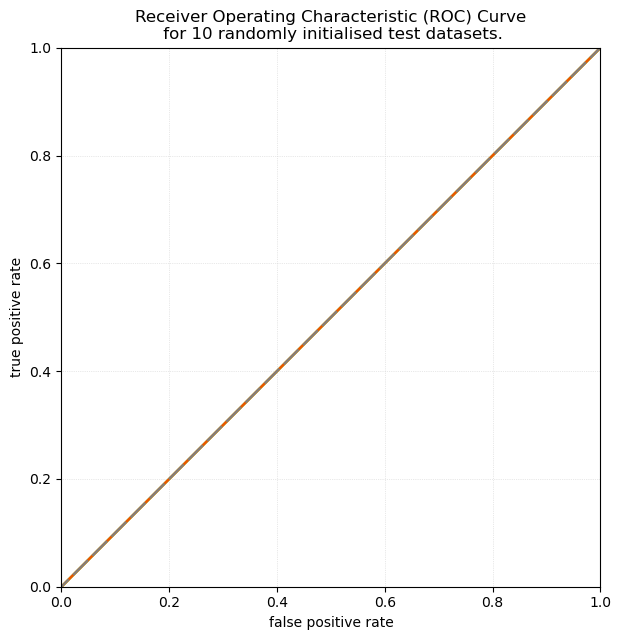

[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=  25.4s
[CV] END criterion=friedman_mse, learning_rate=0.0021544346900318843, loss=huber, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, subsample=0.9; total time=  32.1s


In [93]:
rocs_n_runs(run_outputs['0.08333'])

In [ ]:
1/0.083

In [ ]:
### SST (sea water potential temperature)
# load in daily sea water potential temp
thetao_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/thetao.nc")

# annual average, stdev of annual averages, annual minimum, annual maximum
thetao_annual_average, _, (thetao_annual_min, thetao_annual_max) = baselines.calc_timeseries_params(thetao_daily, "y", "thetao")
# monthly average, stdev of monthly averages, monthly minimum, monthly maximum
thetao_monthly_average, thetao_monthly_stdev, (thetao_monthly_min, thetao_monthly_max) = baselines.calc_timeseries_params(
    thetao_daily, "m", "thetao")
# annual range (monthly max - monthly min)
thetao_annual_range = (thetao_annual_max - thetao_annual_min).rename("thetao_annual_range")
# weekly minimum, weekly maximum
_, _, (thetao_weekly_min, thetao_weekly_max) = baselines.calc_timeseries_params(thetao_daily, "w", "thetao")


In [ ]:
### Salinity
# load in daily sea water salinity means
salinity_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/so.nc")

# annual average
salinity_annual_average, _, _ = baselines.calc_timeseries_params(salinity_daily, "y", "salinity")
# monthly min, monthly max
_, _, (salinity_monthly_min, salinity_monthly_max) = baselines.calc_timeseries_params(salinity_daily, "m", "salinity")

In [ ]:
### Current speed (dot product of horizontal and vertical)
# load in daily currents (longitudinal and latitudinal)
uo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/uo.nc")
vo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/vo.nc")
# calculate current magnitude
current_daily = baselines.calculate_magnitude(uo_daily, vo_daily)

# annual average
current_annual_average, _, _ = baselines.calc_timeseries_params(current_daily, "y", "current")
# monthly min, monthly max
_, _, (current_monthly_min, current_monthly_max) = baselines.calc_timeseries_params(current_daily, "m", "current")

In [ ]:
### Light penetration proxy
# Load in bathymetry and scale to climate variable resolution
bathymetry = xa.open_dataset(
    directories.get_bathymetry_datasets_dir() / "bathymetry_A_0-00030d.nc").rio.write_crs("EPSG:4326")["bathymetry_A"]
bathymetry_climate_res = spatial_data.upsample_xa_d_to_other(bathymetry, thetao_annual_average, name = "bathymetry")



In [ ]:
# Load in ERA5 surface net solar radiation and upscale to climate variable resolution
solar_radiation = xa.open_dataarray(
    directories.get_era5_data_dir() / "weather_parameters/VAR_surface_net_solar_radiation_LATS_-10_-17_LONS_142_147_YEAR_1993-2020.nc"
    ).rio.write_crs("EPSG:4326")
    
# average solar_radiation daily
solar_radiation_daily = solar_radiation.resample(time="1D").mean(dim="time")
solar_climate_res = spatial_data.upsample_xa_d_to_other(solar_radiation_daily, thetao_annual_average, name = "solar_radiation")

# annual average
solar_annual_average, _, _ = baselines.calc_timeseries_params(solar_climate_res, "y", "net_solar")
# monthly min, monthly max
_, _, (solar_monthly_min, solar_monthly_max) = baselines.calc_timeseries_params(solar_climate_res, "m", "net_solar")


In [ ]:
### Load in ground truth data
gt_1000m = xa.open_dataarray(directories.get_processed_dir() / "arrays/coral_raster_1000m.nc")
# upsample to same resolution as climate (1/12 of a degree)
gt_climate_res = spatial_data.upsample_xa_d_to_other(gt_1000m, thetao_annual_average, name = "gt")

In [ ]:
### Display different resolutions
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16,9), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = spatial_plots.plot_spatial(gt_1000m, fax= (fig,ax_left), title="Ground truth coral presence map at 1000m")
ax2 = spatial_plots.plot_spatial(
    gt_climate_res, fax=(fig, ax_right), val_lims = (0,1), title="Ground truth coral presence map at 1/12 degree")

## Baseline Machine Learning Models

In [ ]:
# combine data
all_data = xa.merge([thetao_annual_average, thetao_annual_range, thetao_monthly_min, thetao_monthly_max, 
    thetao_monthly_stdev, thetao_weekly_min, thetao_weekly_max, 
    salinity_annual_average, salinity_monthly_min, salinity_monthly_max,
    current_annual_average, current_monthly_min, current_monthly_max,
    bathymetry_climate_res, solar_annual_average, solar_monthly_min, solar_monthly_max,
    gt_climate_res
    ])
    
all_data

In [ ]:
test_df = all_data.to_dataframe()
# test_df = test_df.dropna(subset=subset, how="any",axis=0)
test_df = test_df.fillna(0)

test_df.describe()

In [ ]:
# drop unnecessary columns
features_df = pd.get_dummies(test_df).drop(["spatial_ref","band","depth","gt"], axis=1)
features_df

In [ ]:
target_df = test_df["gt"]
target_df

In [ ]:
# X_train, X_test, y_train, y_test, train_coordinates,test_coordinates, xa_masked = spatial_split_train_test(
#     all_data, "gt", split_type="pixel", test_fraction = 0.2)

# test_train_da = visualise_train_test_split(all_data, train_coordinates, test_coordinates)
bath_mask = generate_var_mask(all_data)
test_xa = plot_train_test_spatial(test_train_da, bath_mask=bath_mask)


In [ ]:
run_outcomes = n_random_runs_preds(rf_random, 10, all_data)

rocs_n_runs(run_outcomes)

In [ ]:
def investigate_resolution_predictions(xa_ds: xa.DataArray):
    

In [ ]:
out = np.mean(spatial_data.calculate_spatial_resolution(all_data))

In [ ]:
1/out

In [58]:
def investigate_label_thresholds(
    thresholds: list[float],
    y_test: np.ndarray | pd.Series,
    y_predictions: np.ndarray | pd.Series,
    figsize=[7, 7],
):
    """
    Plot ROC curves with multiple lines for different label thresholds.

    Parameters
    ----------
        thresholds (list[float]): List of label thresholds.
        y_test (np.ndarray or pd.Series): True labels.
        y_predictions (np.ndarray or pd.Series): Predicted labels.
        figsize (list, optional): Figure size for the plot. Default is [7, 7].

    Returns
    -------
        None
    """
    # TODO: fix UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless

    f, ax = plt.subplots(figsize=figsize)
    # prepare colour assignment
    color_map = spatial_plots.get_cbar("seq")
    num_colors = len(thresholds)
    colors = [color_map(i / num_colors) for i in range(num_colors)]

    # plot ROC curves
    for c, thresh in enumerate(thresholds):
        binary_y_labels, binary_predictions = model_results.threshold_label(
            y_test, y_predictions, thresh
        )
        fpr, tpr, _ = sklmetrics.roc_curve(
            binary_y_labels, binary_predictions, drop_intermediate=False
        )
        roc_auc = sklmetrics.auc(fpr, tpr)

        label = f"{thresh:.01f} | {roc_auc:.02f}"
        ax.plot(fpr, tpr, label=label, color=colors[c])

    # format
    title = "Receiver Operating Characteristic (ROC) Curve\nfor several coral presence/absence thresholds"
    format_roc(ax=ax, title=title)
    ax.legend(title="threshold value | auc")


def format_roc(ax, title: str = "Receiver Operating Characteristic (ROC) Curve"):
    """
    Format the ROC plot axes.

    Args:
        ax: The matplotlib axes object.
        title (optional): The title of the ROC plot. Defaults to "Receiver Operating Characteristic (ROC) Curve".

    Returns:
        None
    """
    ax.set_title(title)
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_aspect("equal", "box")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])


    # plot "random" line for comparison (y=x)
    ax.plot([0, 1], [0, 1], color='gray', linestyle=(5,(10,3)))
    # Plot the grid
    ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))


In [ ]:
rf_random_preds = rf_random.predict(X_test)

In [ ]:
investigate_label_thresholds(np.linspace(0,1,10), y_test, rf_random_preds)

In [ ]:
RANDOM_STATE = 42
rf_reg = RandomForestRegressor(random_state=RANDOM_STATE)
# rf_reg.get_params()
# rf_random = RandomizedSearchCV(
#     estimator = rf_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
#     random_state=RANDOM_STATE, n_jobs = -1)

rf_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)

In [ ]:
rf_reg.get_params()

In [ ]:
best_rf_params={"n_estimators":400,
"min_samples_split":2,
"min_samples_leaf":4,
"max_features":"sqrt",
"max_depth":10,
"bootstrap":True}

In [ ]:
rf_random = rf_reg.set_params(**best_rf_params)

In [ ]:
rf_random_search_best_params = rf_random.best_params_ 
# save best parameteers to json (in coralshift folder)
import json

with open("rf_random_search_best_params.json", "w") as fp:
    json.dump(rf_random_search_best_params, fp)

In [ ]:
X_test

In [ ]:
# predictions = rf_random.predict(X_test)
# np.shape(predictions)
bce = log_loss(y_true=list(y_test), y_pred=predictions)

In [ ]:
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn import metrics
# predictions = rf_random.predict(X_test)

mean_squared_error(y_test,predictions)

In [ ]:
# predictions = rf_reg.predict(X_test)
# predictions
sum(y_test.where(y_test <= 0,1))

In [ ]:
rf_random.best_params_

In [ ]:
val = 0
for i in range(11):
    print(val, sum(y_test.where(y_test >= val, 1)))
    val += 0.1

In [ ]:
out = np.array(y_test)
sum(np.where(out > 0.1, 1, 0))

In [ ]:

    

rf_reg_preds = rf_reg.predict(X_test)
rf_random_preds = rf_random.predict(X_test)

In [ ]:
np.where(sum(np.array(y_test)) > 0.1, 1, 0)

In [ ]:
# TODO: function to do N model runs and plot resultant ROC
# TODO: test whether training/optimising on binary helps


model_results.investigate_label_thresholds(np.linspace(0,1,100), y_test, rf_reg_preds)


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_labels_bin, predictions_bin, drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                            estimator_name='example estimator')
display.plot()

### Maximum Entropy Model

In [ ]:
from sklearn import preprocessing

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(target_df)

In [ ]:
# maxent = LogisticRegression(random_state=0)
# maxent.fit(features_df, y_transformed)

In [ ]:
# pred_maxent = maxent.predict(features_df)

# predicted_maxent_data = xa.DataArray(pred_maxent.reshape((85,61,28)),
#     coords=all_data.coords, 
#     dims=all_data.dims)

# f,a = plt.subplots(1,2,figsize=[14,7])
# all_data["gt"].plot(ax=a[0])
# predicted_maxent_data.isel(time=-1).plot(ax=a[1]
#     , vmin=all_data["gt"].values.min(), vmax=all_data["gt"].values.max()
#     )

### Classification and Regression Trees (CART)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
clf = RandomForestRegressor()
clf_lim = RandomForestRegressor()

num_vals = 50000
clf.fit(features_df, target_df)
clf_lim.fit(features_df[:num_vals], target_df[:num_vals])
pred_lim = clf_lim.predict(features_df)

In [ ]:
# clf.fit(features_df, target_df)
pred = clf.predict(features_df)
predicted_data = xa.DataArray(pred.reshape((85,61,28)),
    coords=all_data.coords, 
    dims=all_data.dims).isel(time=0)

predicted_lim_data = xa.DataArray(pred_lim.reshape((85,61,28)),
    coords=all_data.coords, 
    dims=all_data.dims).isel(time=0)

In [ ]:
### Compare predicted and ground truth values
spatial_plots.plot_spatial_diffs(predicted_data, gt_climate_res, figsize=(14,13))


In [ ]:
spatial_plots.plot_spatial_diffs(predicted_lim_data, gt_climate_res, figsize=(14,13))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle




def train_test_random_forest(xa_ds: xa.Dataset, target_variable: str = "gt", test_fraction=0.5, random_state=None):
    # TODO: tidy up and document
    # Extract latitude, longitude, and time values from the spatial image
    lats = xa_ds.latitude.values
    lons = xa_ds.longitude.values
    times = xa_ds.time.values


    if len(xa_ds.dims) > 2:
        # Flatten the spatial image into 2D arrays for training and testing
        flattened_data = xa_ds.stack(points=("latitude", "longitude", "time")).compute().to_dataframe().fillna(0).drop(
            ["time","spatial_ref","band","depth"], axis=1).astype("float32")
    else:
        flattened_data = xa_ds.stack(points=("latitude", "longitude")).compute().to_dataframe().fillna(0).drop(
            ["time","spatial_ref","band","depth"], axis=1).astype("float32")

    features = flattened_data.drop("gt", axis=1)
    # flattened_data = np.transpose(flattened_data, axes=(1, 0))
    labels = flattened_data["gt"]

    # # Split the data into training and testing datasets
    # X_train, X_test, y_train, y_test = train_test_split(
    #     features, labels, test_size=test_fraction, random_state=random_state
    # )

    # Train the random forest regressor
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)

    # Predict the target variable for the testing dataset
    y_pred = regressor.predict(X_test)

    train_indices = X_train.index.values
    test_indices = X_test.index.values

    lat_spacing = xa_ds.latitude.values[1] - xa_ds.latitude.values[0]
    lon_spacing = xa_ds.longitude.values[1] - xa_ds.longitude.values[0]

    # TODO: refer to generic data_var dimension rather than calling by variable
    train_pixs = np.empty(xa_ds["thetao_y_mean"].values.shape)
    train_pixs[:] = np.nan
    test_pixs = np.empty(xa_ds["thetao_y_mean"].values.shape)
    test_pixs[:] = np.nan
    # Color the spatial pixels corresponding to training and testing regions
    for train_index in tqdm(train_indices, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, train_index[0], train_index[1], lat_spacing, lon_spacing)
        # ax.add_patch(Rectangle((lons[col], lats[row]), 1, 1, facecolor=train_color, alpha=0.2))
        train_pixs[row,col] = 0

    for test_index in tqdm(test_indices, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, test_index[0], test_index[1], lat_spacing, lon_spacing)
        # ax.add_patch(Rectangle((lons[col], lats[row]), 1, 1, facecolor=test_color, alpha=0.2))
        test_pixs[row,col] = 1


    # ds = xa.Dataset(
    # {
    #     'test_train': (xa_ds.dims, np.nansum(np.stack((test_pixs,train_pixs)), axis=0)),
    # },
    # coords=xa_image.coords)

    return regressor, y_pred, ds


def find_index_pair(data_array, lat, lon, lat_spacing, lon_spacing):
    # Get the latitude and longitude spacing

    lat_values = list(data_array.latitude.values)
    lon_values = list(data_array.longitude.values)

    lat_index = np.where(np.isclose(lat_values, lat))[0][0]
    lon_index = np.where(np.isclose(lon_values, lon))[0][0]

    return lat_index, lon_index

reg,random_pred,ds = train_test_random_forest(all_data.isel(time=0), target_variable=all_data["gt"], random_state=42)

In [ ]:
random_pred_data = xa.DataArray(random_pred.reshape((85,61,28)),
    coords=all_data.coords,
    dims=all_data.dims)


spatial_plots.plot_spatial_diffs(random_pred_data, gt_climate_res, figsize=(14,13))



In [ ]:
def plot_train_test_spatial(dataset, figsize: tuple[float,float] = (7,7)):
    """
    Plot two spatial variables from a dataset with different colors and labels.

    Parameters:
    dataset (xarray.Dataset): The dataset containing the variables.

    Returns:
    None
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize = figsize, subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Plot variable1 with color and label
    dataset["train_pixs"].plot(ax=ax, vmin=0, vmax=1, levels=2, label="train_pixs",add_colorbar=False)

    # Plot variable2 with color and label
    dataset["test_pixs"].plot(ax=ax, vmin=0, vmax=1, levels=2, label="test_pixs", add_colorbar=False)
    ax.set_aspect("equal")
    ax.coastlines(resolution="10m", color="red", linewidth=3)
    # Add a colorbar for each variable
    # cbar1 = plt.colorbar(ax=ax, mappable=dataset["train_pixs"])
    # cbar2 = plt.colorbar(ax=ax, mappable=dataset["test_pixs"])
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)




plot_train_test_spatial(ds)




In [ ]:


def plot_categorical_data(dataset, variable_name,  color1='red', color2='blue'):
    """
    Plot categorical spatial data from an xarray dataset.

    Parameters:
    dataset (xarray.Dataset): The dataset containing the categorical data.
    variable_name (str): The name of the variable in the dataset to plot.

    Returns:
    None
    """
    # Extract the required data variable
    variable = dataset[variable_name]

    # Get the latitude, longitude, and values arrays
    latitudes = variable.latitude.values
    longitudes = variable.longitude.values
    values = variable.values

    # Create a meshgrid from latitude and longitude arrays
    lon_mesh, lat_mesh = np.meshgrid(longitudes, latitudes)

    # Plot the categorical data
    mask1 = values == 0
    mask2 = values == 1

    # Plot the binary categorical data
    plt.pcolormesh(lon_mesh, lat_mesh, mask1, cmap='Greys', facecolor=color1)
    plt.pcolormesh(lon_mesh, lat_mesh, mask2, cmap='Greys', facecolor=color2)

    # Add colorbar and labels
    # plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(variable_name)
    plt.legend()
    # Show the plot
    plt.show()

plot_categorical_data(ds,"test_train")


In [ ]:
ds

In [ ]:
all_data

In [ ]:


predicted_lim_data = xa.DataArray(pred_lim.reshape((85,61,28)),
    # coords=all_data.coords, 
    dims=all_data.dims)

f,a = plt.subplots(1,2,figsize=[14,7])
predicted_data.isel(time=0).plot(ax=a[0])
predicted_lim_data.isel(time=0).plot(ax=a[1], vmin=predicted_data.min(), vmax=predicted_data.max())

In [ ]:
# TODO: training and testing on subsamples of data (train_test_split for linear, somehow something spatial...)
# add in bathymetry
# try binary (classifier)
# function to plot difference between predicted and true
# hyperparameter tuning

### Boosted Regression Trees (BRT)

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [ ]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    features_df, target_df, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
X_train_t

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_df.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_df.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
gbr_pred = reg.predict(features_df)

In [ ]:

predicted_gbr_data = xa.DataArray(gbr_pred.reshape((85,61,28)),
    coords=all_data.coords, 
    dims=all_data.dims).isel(time=0)


spatial_plots.plot_spatial_diffs(predicted_gbr_data, gt_climate_res, figsize=(14,13))



# f,a = plt.subplots(1,2,figsize=[14,7])
# all_data["gt"].plot(ax=a[0])
# predicted_gbr_data.isel(time=-1).plot(ax=a[1]
#     , vmin=all_data["gt"].values.min(), vmax=all_data["gt"].values.max()
#     )